In [20]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


#Don't need t=0.
df = pd.read_csv('../Data/ApixibanExperimentData.csv')
df.Concentration = 10e-3*df.Concentration

#Create a table of data. Subjects x Time
Ys = df.query('Time>0').pivot('Subject','Time','Concentration')
Y = Ys.values

t = np.array([0.5, 1 ,2 ,4 ,6 ,8 ,10 ,12])

#Vectorize the function
@np.vectorize
def func(t,V,k,ka,k12,k21):
    t1 = k ** 2
    t2 = k * k12
    t4 = k * k21
    t6 = k12 ** 2
    t9 = k21 ** 2
    t11 = np.sqrt(2 * k12 * k21 + t1 + 2 * t2 - 2 * t4 + t6 + t9)
    t12 = -k - k12 - k21 + t11
    t15 = np.exp(t12 * t / 2)
    t19 = t11 * k
    t37 = 2 * k21 * k12 * t11 - t1 * k - 3 * t6 * k - 3 * t1 * k12 + 2 * k12 * t19 + t1 * k21 - 2 * k21 * t19 + 2 * ka * t1 + t1 * t11 + t6 * t11 + t9 * t11
    t52 = k12 * ka
    t58 = t9 * k - t6 * k12 - 3 * t9 * k12 - 2 * k21 * t2 + 4 * k21 * t52 - 3 * k21 * t6 - t9 * k21 + 4 * ka * t2 - 4 * ka * t4 + 2 * ka * t6 + 2 * ka * t9
    t60 = 0.1e1 / (t37 + t58)
    t64 = ka ** 2
    t65 = -k * ka - k21 * ka + t4 - t52 + t64
    t69 = -k - k12 - k21 - t11
    t72 = np.exp(t69 * t / 2)
    t74 = 0.1e1 / t11
    t78 = 0.1e1 / (-t11 - k - k12 - k21 + 2 * ka)
    t84 = np.exp(-ka * t)
    y = (k21 * (10 * t65 * t60 * ka * k12 * t11 * t15 - 10 * t65 * t78 * k12 * t74 * ka * t72 + 5 * ka * t84 * k12) + 5 * t12 * t15 * t11 * t52 * t60 * t65 - 5 * t69 * t72 * ka * t74 * k12 * t78 * t65 - 5 * k12 * t64 * t84) / t65 / V / k12 / 2
    
    return y 



YHAT = np.zeros(shape = Y.shape)

for i,y in enumerate(Y):

    p,c = curve_fit(func,xdata=t,ydata=y, p0= [100,1,1/2,0.1,0.1], bounds=(5*[0], 5*[np.inf]))

    y_hat = func(t,*p)
    
    YHAT[i,:] = y_hat
    
    print(p[-2::].round(2))


[  0.   145.66]
[3.000e-02 4.366e+01]
[ 0.   30.19]
[0.36 0.03]
[  0.   298.67]
[ 0.   45.53]
[  0.   239.62]
[ 0.   25.22]
[20.41  6.87]
[ 0.13 43.68]
[10.78  0.66]
[  2.71 126.76]
[ 0.   25.02]
[ 0.   68.88]
[0.22 0.05]
[4.0000e-02 6.2093e+02]
[ 0.   61.55]
[ 1.43 29.94]
[0.46 0.04]
[2.7000e-01 9.9414e+02]
[  0.   110.68]
[ 0.   62.36]
[  0.   545.77]
[3.0000e-02 1.4296e+02]
[0.   0.83]
[ 0.   47.49]
[ 0.   23.94]
[ 0.19 19.79]
[ 0.   33.46]
[0.35 0.01]
[  0.   130.87]
[ 0.   15.98]
[44.69  3.82]
[2.000e-02 4.012e+01]
[  0.   309.04]
[ 0.07 34.72]


array([ 2.57184131,  0.2215415 ,  0.22454153,  0.07093629, 34.72354573])

In [4]:
preds = pd.DataFrame(YHAT, index=Ys.index, columns=Ys.columns).stack().to_frame('predicted').reset_index()

In [5]:
m = preds.merge(df, on=['Subject','Time'], how = 'inner')

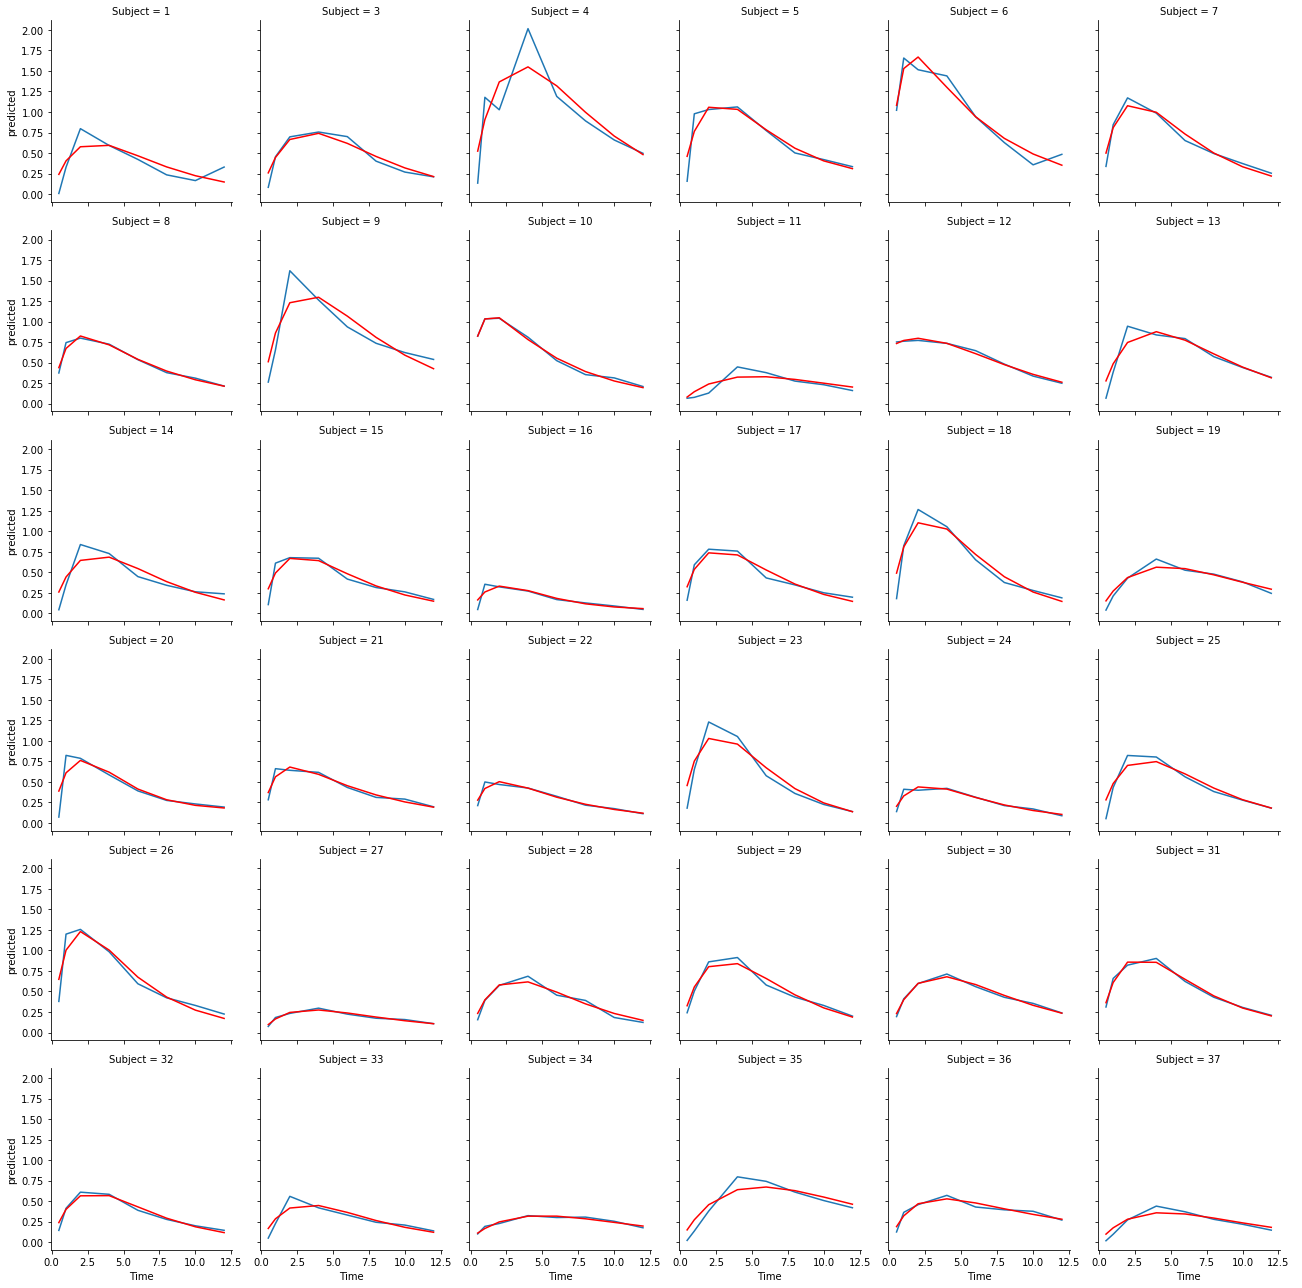

In [6]:
g = sns.FacetGrid(data = m, col = 'Subject', col_wrap=6)

g.map(plt.plot,'Time','Concentration').add_legend()
g.map(plt.plot,'Time','predicted', color = 'red')

In [7]:
m['residual'] = m.Concentration - m.predicted

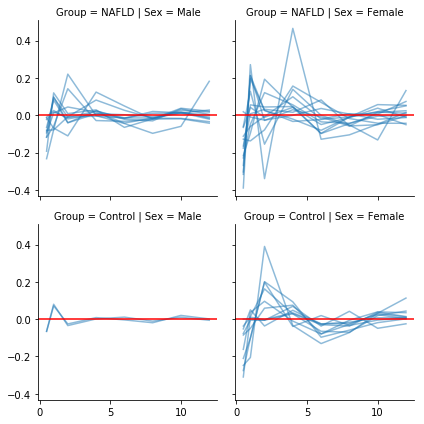

In [21]:

g = sns.FacetGrid(data = m, col='Sex', row = 'Group')


def f(x,y,z,*args,**kwargs):
    
    return sns.lineplot(x = x, 
                        y = y,
                        units = z,
                        estimator = None,
                        *args, 
                        **kwargs)


g.map(f, 'Time','residual','Subject', alpha = 0.5)
g.map(plt.axhline,color = 'red')
plt.tight_layout()

plt.savefig("2comp.pdf")

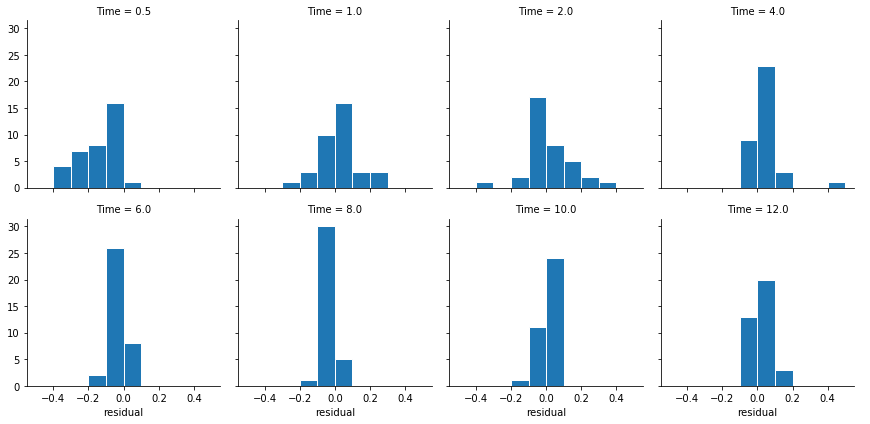

In [9]:
g = sns.FacetGrid(data = m, col='Time', col_wrap=4)

g.map(plt.hist,'residual', bins = np.linspace(-0.5,0.5,11), edgecolor = 'white').add_legend()

plt.tight_layout()
plt.savefig('res.pdf')


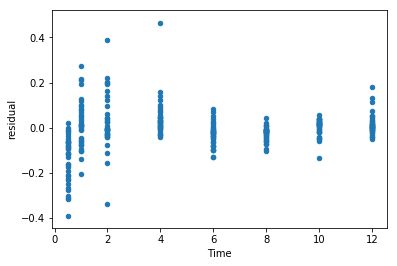

In [10]:
ax = m.plot.scatter(x = 'Time', y = 'residual')


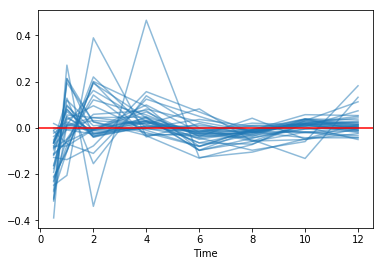

In [11]:
ax = m.pivot('Time','Subject','residual').plot(color = 'C0', legend = False, alpha = 0.5)
ax.axhline(0, color = 'red')


/Users/demetri/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


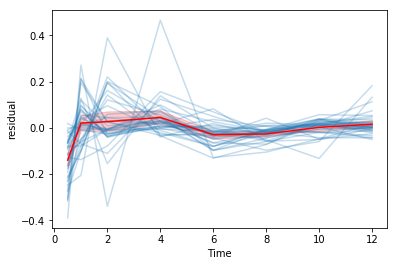

In [12]:
sns.lineplot(data = m, x = 'Time',y = 'residual', units = 'Subject', estimator=None, alpha = 0.25)
sns.lineplot(data = m, x = 'Time',y = 'residual', color = 'red')

In [13]:
m.round(2).to_clipboard(index = False)

In [15]:
m.groupby(['Sex','Group']).Subject.nunique()

Sex     Group  
Female  Control    10
        NAFLD      13
Male    Control     2
        NAFLD      11
Name: Subject, dtype: int64